In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from netam import shmoof, noof

In [2]:
train_df, val_df = shmoof.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv") #, sample_count=5000)

In [3]:
kmer_length = 5
max_length = 410

train_dataset = shmoof.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = shmoof.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 35830 training examples and 13186 validation examples


In [4]:
model = shmoof.SHMoofModel(train_dataset)
burrito = shmoof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=100)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/100]	 Loss: 0.064708303	 Val Loss: 0.068095603
Epoch [2/100]	 Loss: 0.059384526	 Val Loss: 0.067468772
Epoch [3/100]	 Loss: 0.059186031	 Val Loss: 0.067386325
Epoch [4/100]	 Loss: 0.059106271	 Val Loss: 0.067281711
Epoch [5/100]	 Loss: 0.059058513	 Val Loss: 0.067231785
Epoch [6/100]	 Loss: 0.059008698	 Val Loss: 0.0671629
Epoch [7/100]	 Loss: 0.058970683	 Val Loss: 0.067160752
Epoch [8/100]	 Loss: 0.058925471	 Val Loss: 0.067094451
Epoch [9/100]	 Loss: 0.058901728	 Val Loss: 0.067037245
Epoch [10/100]	 Loss: 0.058872717	 Val Loss: 0.067006343
Epoch [11/100]	 Loss: 0.058843163	 Val Loss: 0.066936878
Epoch [12/100]	 Loss: 0.058824266	 Val Loss: 0.066950845
Epoch [13/100]	 Loss: 0.058784614	 Val Loss: 0.066928061
Epoch [14/100]	 Loss: 0.058765824	 Val Loss: 0.066900291
Epoch [15/100]	 Loss: 0.058738424	 Val Loss: 0.066904187
Epoch [16/100]	 Loss: 0.058729954	 Val Loss: 0.066830375
Epoch [17/100]	 Loss: 0.058703767	 Val Loss: 0.066813474
Epoch [18/100]	 Loss:

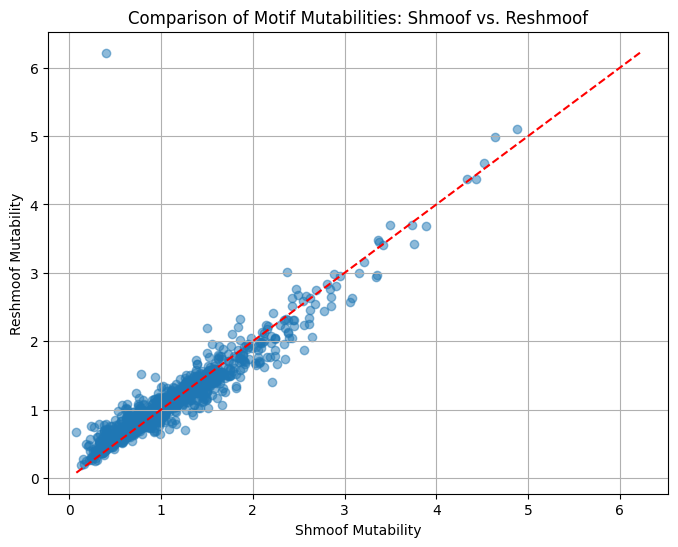

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

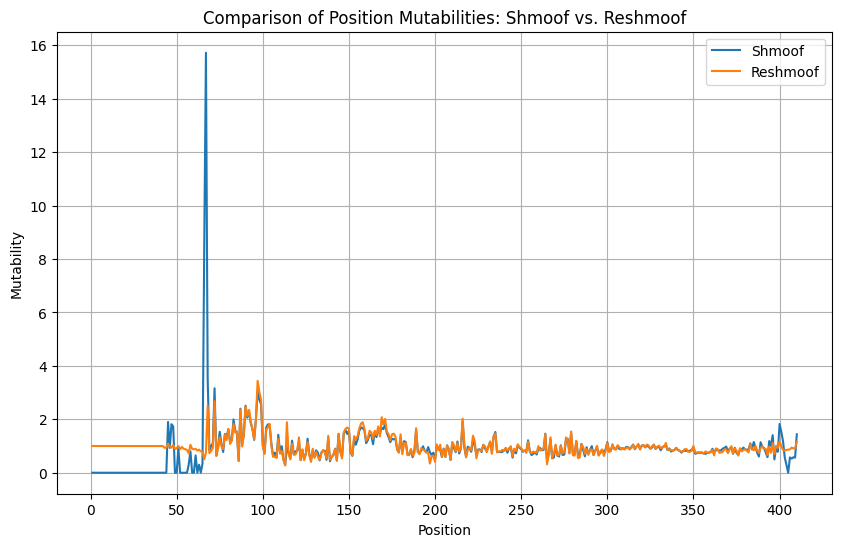

In [6]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()


Training with regularization coefficient 0
Epoch [1/20]	 Loss: 0.06307265	 Val Loss: 0.066809178
Epoch [2/20]	 Loss: 0.058526971	 Val Loss: 0.066512177
Epoch [3/20]	 Loss: 0.058442165	 Val Loss: 0.066479509
Epoch [4/20]	 Loss: 0.058429818	 Val Loss: 0.06647629
Epoch [5/20]	 Loss: 0.058448284	 Val Loss: 0.066542333
Epoch [6/20]	 Loss: 0.058444783	 Val Loss: 0.066537744
Epoch [7/20]	 Loss: 0.058446079	 Val Loss: 0.066543828
Epoch [8/20]	 Loss: 0.05844685	 Val Loss: 0.066539851
Epoch 00008: reducing learning rate of group 0 to 2.0000e-02.
Epoch [9/20]	 Loss: 0.058335435	 Val Loss: 0.066395582
Epoch [10/20]	 Loss: 0.05828791	 Val Loss: 0.066381257
Epoch [11/20]	 Loss: 0.058285243	 Val Loss: 0.066382121
Epoch [12/20]	 Loss: 0.058287347	 Val Loss: 0.066372282
Epoch [13/20]	 Loss: 0.05828975	 Val Loss: 0.066384339
Epoch [14/20]	 Loss: 0.058287247	 Val Loss: 0.066385155
Epoch [15/20]	 Loss: 0.058289172	 Val Loss: 0.066381501
Epoch [16/20]	 Loss: 0.058288459	 Val Loss: 0.066387276
Epoch [17/20]

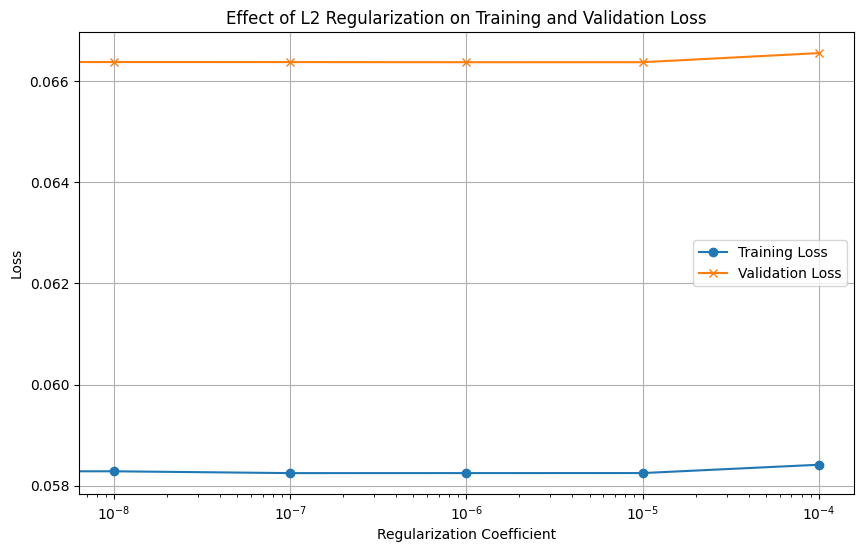

In [7]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = shmoof.SHMoofModel(train_dataset)
    burrito = shmoof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
    loss_history = burrito.train(epochs=20)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
